In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Imbalance for the cross-validation   

df = pd.read_csv('blood_transfusion.csv', na_values=['NA', 'null', '', 'NULL']) 

df = df.drop(columns=['total_blood_donated'])

# Seeing in the dataset if there are records that have donated more than once per month
loc_df_total_minus_last = (df['months_since_first_donation'] - df['months_since_last_donation']) + 1
df = df[df['total_number_of_donations'] <= loc_df_total_minus_last]

df_with_freq = df.copy()
df_with_freq['Average_frequency_donations'] = df['months_since_first_donation'] / df['total_number_of_donations']

df.describe()

loc_df_class_0 = df.loc[df['class'] == 0]
loc_df_class_1 = df.loc[df['class'] == 1]
loc_df_class_0_with_freq = df_with_freq.loc[df['class'] == 0]
loc_df_class_1_with_freq = df_with_freq.loc[df['class'] == 1]

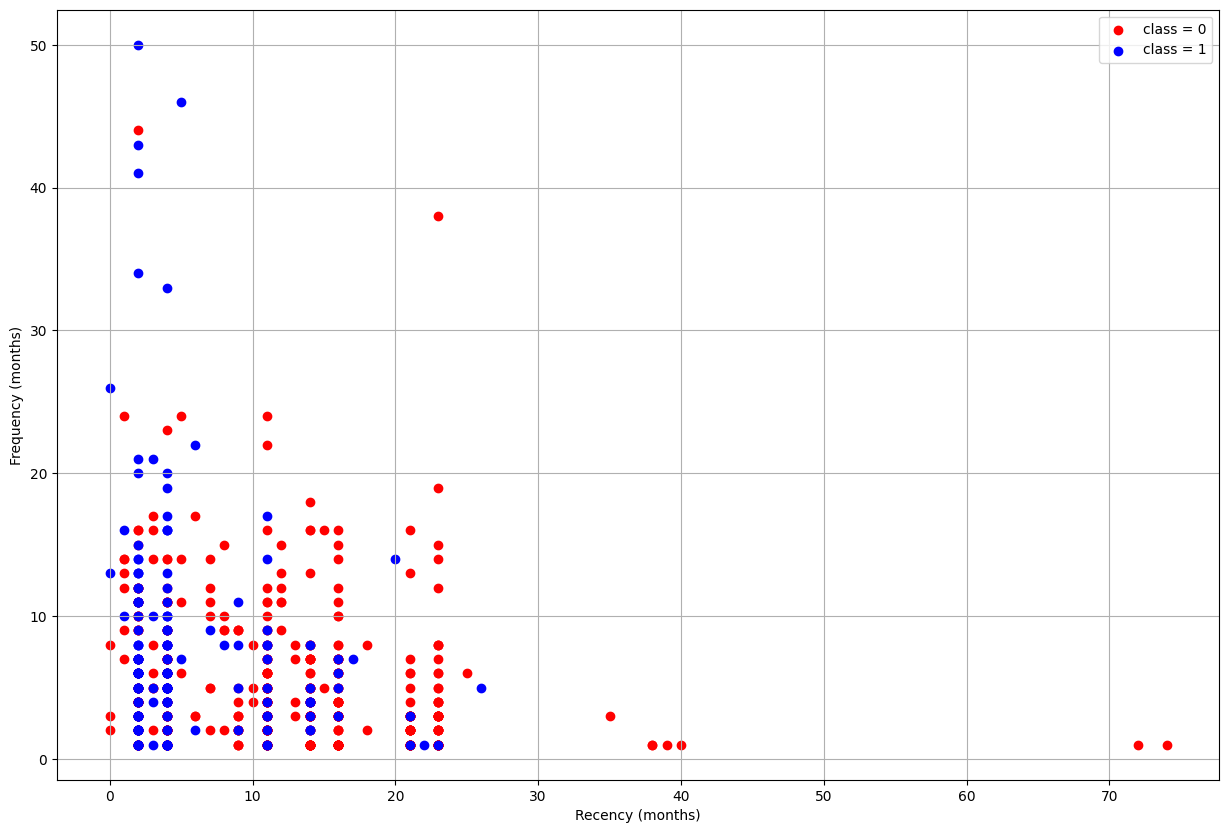

In [63]:


# plot the data showing the difference in the two classes 0 and 1
# make the graph bigger to see the data more clearly
# insert so that graph shows all intergers on the x and y axis
plt.figure(figsize=(15, 10))
plt.scatter(loc_df_class_0['months_since_last_donation'], loc_df_class_0['total_number_of_donations'], color='red', label='class = 0')
plt.scatter(loc_df_class_1['months_since_last_donation'], loc_df_class_1['total_number_of_donations'], color='blue', label='class = 1')
plt.xlabel('Recency (months)')
plt.ylabel('Frequency (months)')
plt.legend()
plt.grid()
plt.show()


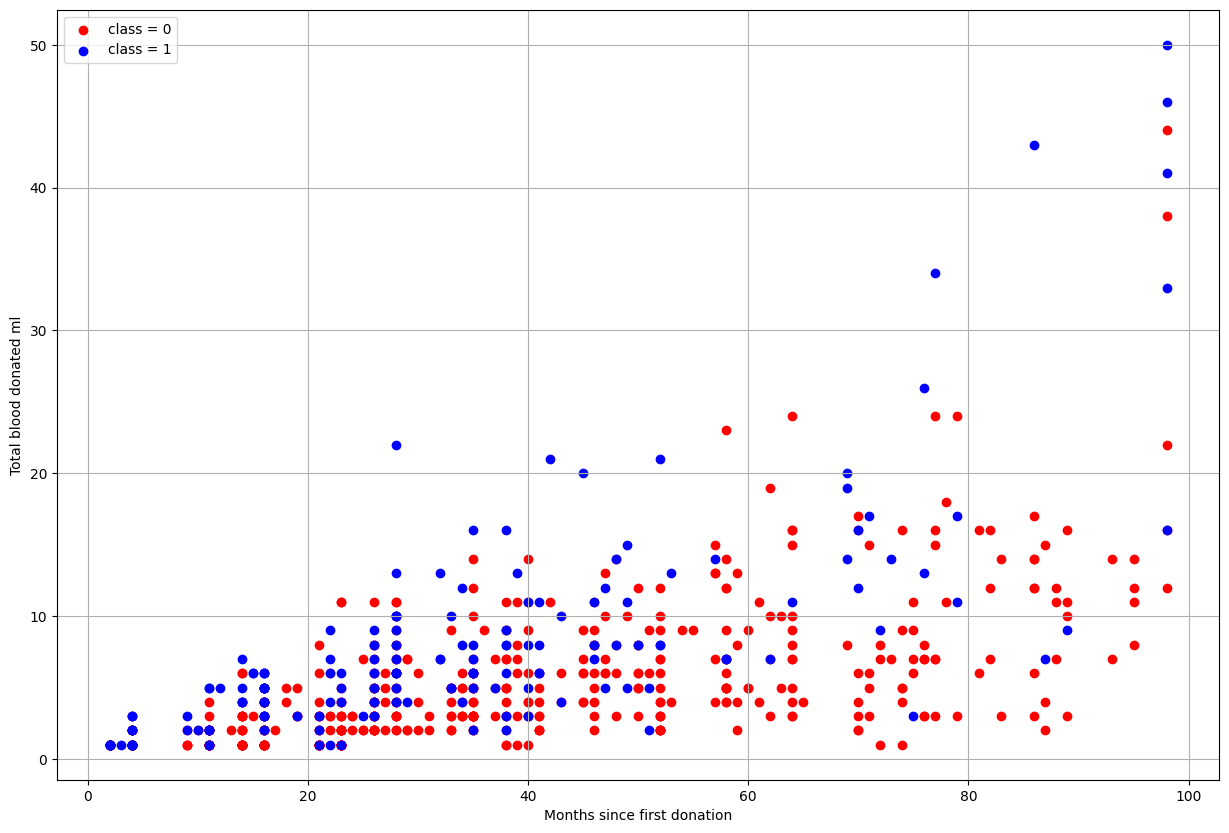

In [64]:
df.describe()
loc_df_class_0 = df.loc[df['class'] == 0]
loc_df_class_1 = df.loc[df['class'] == 1]

# plot the data showing the difference in the two classes 0 and 1
# make the graph bigger to see the data more clearly
# insert so that graph shows all intergers on the x and y axis
plt.figure(figsize=(15, 10))
plt.scatter(loc_df_class_0['months_since_first_donation'], loc_df_class_0['total_number_of_donations'], color='red', label='class = 0')
plt.scatter(loc_df_class_1['months_since_first_donation'], loc_df_class_1['total_number_of_donations'], color='blue', label='class = 1')
plt.xlabel('Months since first donation')
plt.ylabel('Total blood donated ml')
plt.legend()
plt.grid()

plt.show()

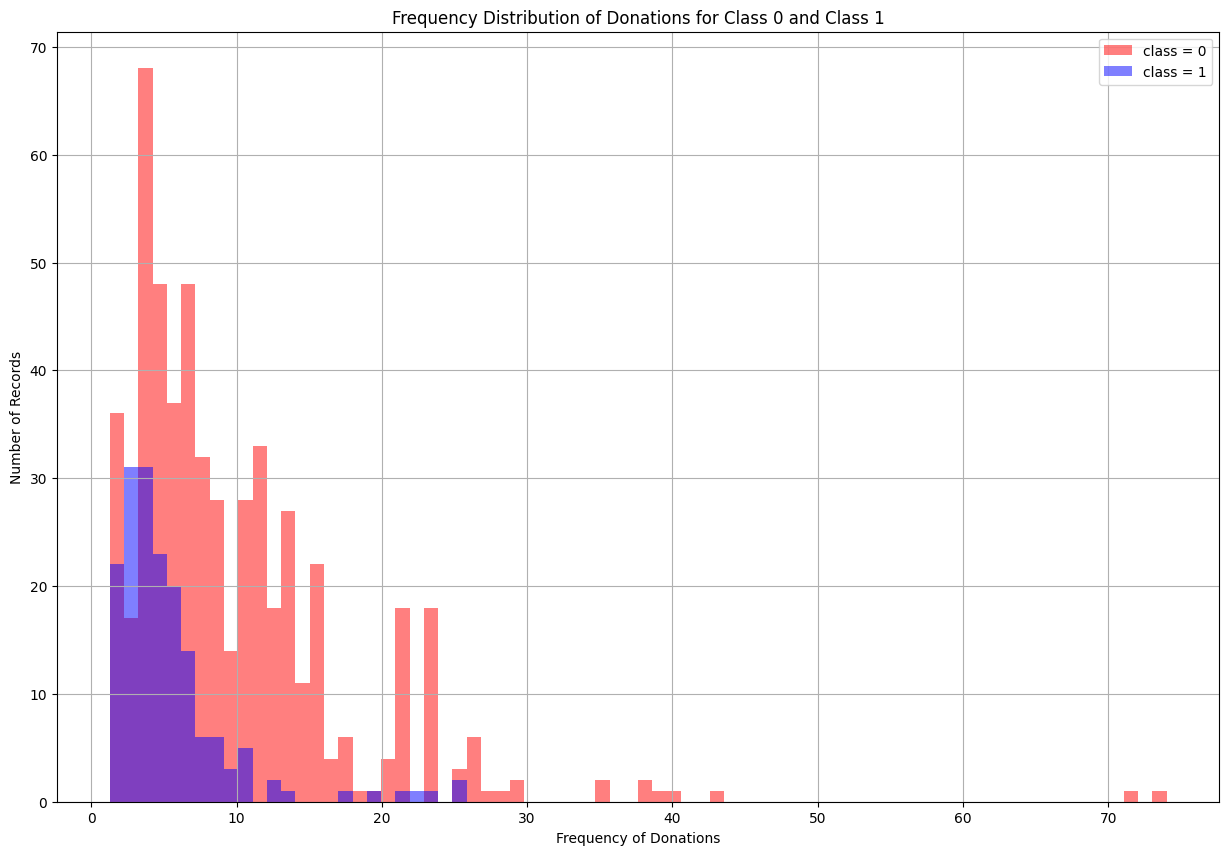

In [65]:
import numpy as np
import matplotlib.pyplot as plt

freq_class_0 = loc_df_class_0_with_freq['Average_frequency_donations']
freq_class_1 = loc_df_class_1_with_freq['Average_frequency_donations']

# Define the number of bins (adjust based on your data distribution)
bins = np.linspace(min(freq_class_0.min(), freq_class_1.min()), max(freq_class_0.max(), freq_class_1.max()), 75)

plt.figure(figsize=(15, 10))

# Create a histogram for class 0
hist_class_0, bins_class_0 = np.histogram(freq_class_0, bins=bins)
plt.bar(bins_class_0[:-1], hist_class_0, width=np.diff(bins_class_0), align='edge', color='red', alpha=0.5, label='class = 0')

# Create a histogram for class 1
hist_class_1, bins_class_1 = np.histogram(freq_class_1, bins=bins)
plt.bar(bins_class_1[:-1], hist_class_1, width=np.diff(bins_class_1), align='edge', color='blue', alpha=0.5, label='class = 1')

plt.xlabel('Frequency of Donations')
plt.ylabel('Number of Records')
plt.title('Frequency Distribution of Donations for Class 0 and Class 1')
plt.legend()
plt.grid()
plt.show()

In [66]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler


# Split the data for training and testing
X = df.drop(columns=['class'])
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train SVM on balanced data
scaler_balanced = StandardScaler()
X_train_scaled_balanced = scaler_balanced.fit_transform(X_train_res)
X_test_scaled_balanced = scaler_balanced.transform(X_test)

In [67]:
# Define a confusion matrix function
def confusion_matrix(pred, original):
    matrix = np.zeros((2, 2))
    for i in range(len(pred)):
        if int(pred[i]) == 1 and int(original.iloc[i]) == 1: 
            matrix[0, 0] += 1
        elif int(pred[i]) == 1 and int(original.iloc[i]) == 0:
            matrix[0, 1] += 1
        elif int(pred[i]) == 0 and int(original.iloc[i]) == 1:
            matrix[1, 0] += 1
        elif int(pred[i]) == 0 and int(original.iloc[i]) == 0:
            matrix[1, 1] += 1
    return matrix

In [68]:
import math
from sklearn.metrics import classification_report


def euclidean_distance(point1, point2):
    distance = 0.0
    for i in range(len(point1)):
        distance += (point1[i] - point2[i]) ** 2
    return math.sqrt(distance)

def knn_classifier(X_train, y_train, X_test, k=3):
    pred = []
    for test in X_test:
        distances = []
        for i in range(len(X_train)):
            dist = euclidean_distance(test, X_train[i])
            distances.append((dist, y_train[i]))
        distances.sort() # sort based on distance
        neighbors = distances[:k] # get the K nearest neigb
        classes = []
        for neighbor in neighbors:
            classes.append(neighbor[1])
        predicted_class = max(set(classes), key=classes.count)
        pred.append(predicted_class)
    return pred

# Assuming df is your DataFrame and 'class' is the column with labels
df_KNN = df.copy()
df_KNN_with_freq = df_with_freq.copy()


X = df_KNN.drop(columns=['class'])
y = df_KNN['class']

# standard scalar is by default z-score normalization
df_KNN = scaler.fit_transform(df_KNN)
# Ensure all data is numeric
X = X.astype(float)

predicted_labels = knn_classifier(X_train.values, y_train.values, X_test.values, k=3)

confusion_knn_imbalance = confusion_matrix(predicted_labels, y_test)
print("Confusion Matrix (Imbalanced KNN):\n", confusion_knn_imbalance)
print("Classification Report (Imbalanced KNN):\n", classification_report(y_test, predicted_labels, target_names=['class 0', 'class 1']))


predicted_labels_balanced = knn_classifier(X_train_res.values, y_train_res.values, X_test.values, k=3)

confusion_knn_balanced = confusion_matrix(predicted_labels_balanced, y_test)
print("Confusion Matrix (Balanced KNN):\n", confusion_knn_balanced)
print("Classification Report (Balanced KNN):\n", classification_report(y_test, predicted_labels_balanced, target_names=['class 0', 'class 1']))

for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {X_test.iloc[i]}")

Confusion Matrix (Imbalanced KNN):
 [[ 8. 19.]
 [28. 88.]]
Classification Report (Imbalanced KNN):
               precision    recall  f1-score   support

     class 0       0.76      0.82      0.79       107
     class 1       0.30      0.22      0.25        36

    accuracy                           0.67       143
   macro avg       0.53      0.52      0.52       143
weighted avg       0.64      0.67      0.65       143

Confusion Matrix (Balanced KNN):
 [[17. 32.]
 [19. 75.]]
Classification Report (Balanced KNN):
               precision    recall  f1-score   support

     class 0       0.80      0.70      0.75       107
     class 1       0.35      0.47      0.40        36

    accuracy                           0.64       143
   macro avg       0.57      0.59      0.57       143
weighted avg       0.68      0.64      0.66       143

Predicted: 0, Actual: months_since_last_donation      2.0
total_number_of_donations       4.0
months_since_first_donation    14.0
Name: 531, dtype: fl

In [69]:
from sklearn.naive_bayes import GaussianNB


# Train Naive Bayes on imbalanced data
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_imbalanced = gnb.predict(X_test)
confusion_naive_imbalance = confusion_matrix(y_pred_imbalanced, y_test)
print("Confusion Matrix (Imbalanced Naive Bayes):\n", confusion_naive_imbalance)
print("Classification Report (Imbalanced Naive Bayes):\n", classification_report(y_test, y_pred_imbalanced, target_names=['class 0', 'class 1']))

# Train Naive Bayes on balanced data
gnb.fit(X_train_res, y_train_res)
y_pred_balanced = gnb.predict(X_test)
confusion_naive_balance = confusion_matrix(y_pred_balanced, y_test)
print("Confusion Matrix (Balanced Naive Bayes):\n", confusion_naive_balance)
print("Classification Report (Balanced Naive Bayes):\n", classification_report(y_test, y_pred_balanced, target_names=['class 0', 'class 1']))


Confusion Matrix (Imbalanced Naive Bayes):
 [[  2.   5.]
 [ 34. 102.]]
Classification Report (Imbalanced Naive Bayes):
               precision    recall  f1-score   support

     class 0       0.75      0.95      0.84       107
     class 1       0.29      0.06      0.09        36

    accuracy                           0.73       143
   macro avg       0.52      0.50      0.47       143
weighted avg       0.63      0.73      0.65       143

Confusion Matrix (Balanced Naive Bayes):
 [[26. 56.]
 [10. 51.]]
Classification Report (Balanced Naive Bayes):
               precision    recall  f1-score   support

     class 0       0.84      0.48      0.61       107
     class 1       0.32      0.72      0.44        36

    accuracy                           0.54       143
   macro avg       0.58      0.60      0.52       143
weighted avg       0.71      0.54      0.57       143



In [70]:
from sklearn import svm

# Train SVM on imbalanced data
svc_clf_imbalanced = svm.SVC()
svc_clf_imbalanced.fit(X_train_scaled, y_train)
y_pred_svc_imbalanced = svc_clf_imbalanced.predict(X_test_scaled)
confusion_svc_imbalance = confusion_matrix(y_pred_svc_imbalanced, y_test)
print("Confusion Matrix (Imbalanced SVM):\n", confusion_svc_imbalance)
print("Classification Report (Imbalanced SVM):\n", classification_report(y_test, y_pred_svc_imbalanced, target_names=['class 0', 'class 1']))

svc_clf_balanced = svm.SVC()
svc_clf_balanced.fit(X_train_scaled_balanced, y_train_res)
y_pred_svc_balanced = svc_clf_balanced.predict(X_test_scaled_balanced)
confusion_svc_balance = confusion_matrix(y_pred_svc_balanced, y_test)
print("Confusion Matrix (Balanced SVM):\n", confusion_svc_balance)
print("Classification Report (Balanced SVM):\n", classification_report(y_test, y_pred_svc_balanced, target_names=['class 0', 'class 1']))


Confusion Matrix (Imbalanced SVM):
 [[  3.   1.]
 [ 33. 106.]]
Classification Report (Imbalanced SVM):
               precision    recall  f1-score   support

     class 0       0.76      0.99      0.86       107
     class 1       0.75      0.08      0.15        36

    accuracy                           0.76       143
   macro avg       0.76      0.54      0.51       143
weighted avg       0.76      0.76      0.68       143

Confusion Matrix (Balanced SVM):
 [[20. 35.]
 [16. 72.]]
Classification Report (Balanced SVM):
               precision    recall  f1-score   support

     class 0       0.82      0.67      0.74       107
     class 1       0.36      0.56      0.44        36

    accuracy                           0.64       143
   macro avg       0.59      0.61      0.59       143
weighted avg       0.70      0.64      0.66       143



In [71]:
from sklearn.neural_network import MLPClassifier

# Train MLP on imbalanced data
mlp_clf_imbalanced = MLPClassifier(max_iter=1000, random_state=42)
mlp_clf_imbalanced.fit(X_train_scaled, y_train)
y_pred_mlp_imbalanced = mlp_clf_imbalanced.predict(X_test_scaled)
confusion_mlp_imbalance = confusion_matrix(y_pred_mlp_imbalanced, y_test)
print("Confusion Matrix (Imbalanced MLP):\n", confusion_mlp_imbalance)
print("Classification Report (Imbalanced MLP):\n", classification_report(y_test, y_pred_mlp_imbalanced, target_names=['class 0', 'class 1']))

# Train MLP on balanced data
mlp_clf_balanced = MLPClassifier(max_iter=1000, random_state=42)
mlp_clf_balanced.fit(X_train_scaled_balanced, y_train_res)
y_pred_mlp_balanced = mlp_clf_balanced.predict(X_test_scaled_balanced)
confusion_mlp_balance = confusion_matrix(y_pred_mlp_balanced, y_test)
print("Confusion Matrix (Balanced MLP):\n", confusion_mlp_balance)
print("Classification Report (Balanced MLP):\n", classification_report(y_test, y_pred_mlp_balanced, target_names=['class 0', 'class 1']))


Confusion Matrix (Imbalanced MLP):
 [[  1.   1.]
 [ 35. 106.]]
Classification Report (Imbalanced MLP):
               precision    recall  f1-score   support

     class 0       0.75      0.99      0.85       107
     class 1       0.50      0.03      0.05        36

    accuracy                           0.75       143
   macro avg       0.63      0.51      0.45       143
weighted avg       0.69      0.75      0.65       143

Confusion Matrix (Balanced MLP):
 [[20. 32.]
 [16. 75.]]
Classification Report (Balanced MLP):
               precision    recall  f1-score   support

     class 0       0.82      0.70      0.76       107
     class 1       0.38      0.56      0.45        36

    accuracy                           0.66       143
   macro avg       0.60      0.63      0.61       143
weighted avg       0.71      0.66      0.68       143

